## 📦 Loading the Dataset from Kaggle

The dataset is downloaded directly from Kaggle using the `kagglehub` package. This approach ensures that the most recent version of the dataset is used automatically.

Steps performed in this cell:

- Download the *Superstore Sales* dataset from Kaggle
- Locate the path to the extracted CSV file
- Read the CSV into a pandas DataFrame using `latin1` encoding (to handle special characters)
- Clean column names by:
  - Stripping leading/trailing spaces
  - Replacing spaces with underscores for easier reference

This sets up the data for further cleaning, exploration, and visualization.


In [6]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Download latest version
path = kagglehub.dataset_download("vivek468/superstore-dataset-final")
filepath = os.path.join(path, os.listdir(path)[0]) 
print("Path to dataset files:\n", filepath )
df = pd.read_csv(filepath, encoding="latin1")
df.columns = df.columns.str.strip().str.replace(" ", "_")


Path to dataset files:
 C:\Users\sanaz\.cache\kagglehub\datasets\vivek468\superstore-dataset-final\versions\1\Sample - Superstore.csv


## 📈 Monthly Sales Trend

This plot shows how sales have changed month over month.  
Sales tend to peak in November and December, indicating seasonal buying behavior, likely due to holidays.

Business Implication:  
Plan inventory and promotions in Q4 to take advantage of these peaks.


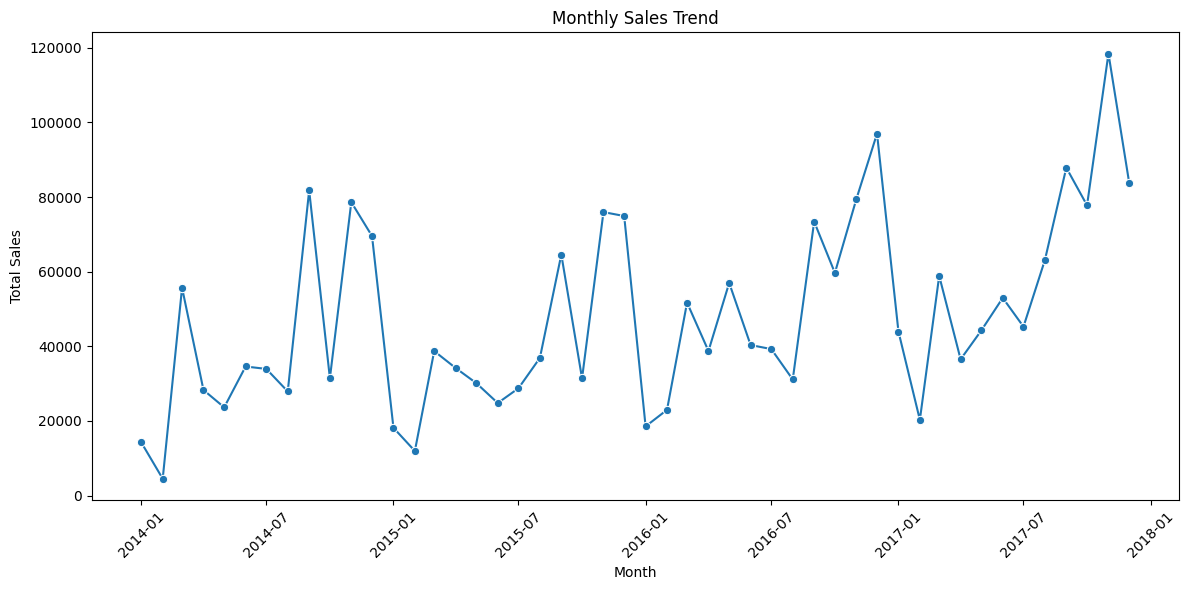

In [7]:
# Group sales by month
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Month'] = df['Order_Date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Sales'].sum().reset_index()

# Convert to datetime (for plotting)
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 📊 Sales by Product Category

This bar chart shows the total sales by product category.  
It highlights which categories generate the most revenue overall.

**Key Insight:**  
The *Technology* category brings in the highest sales, followed by *Furniture* and *Office Supplies*.

**Business Implication:**  
Focus marketing, upselling, and inventory strategy around high-performing categories like Technology.


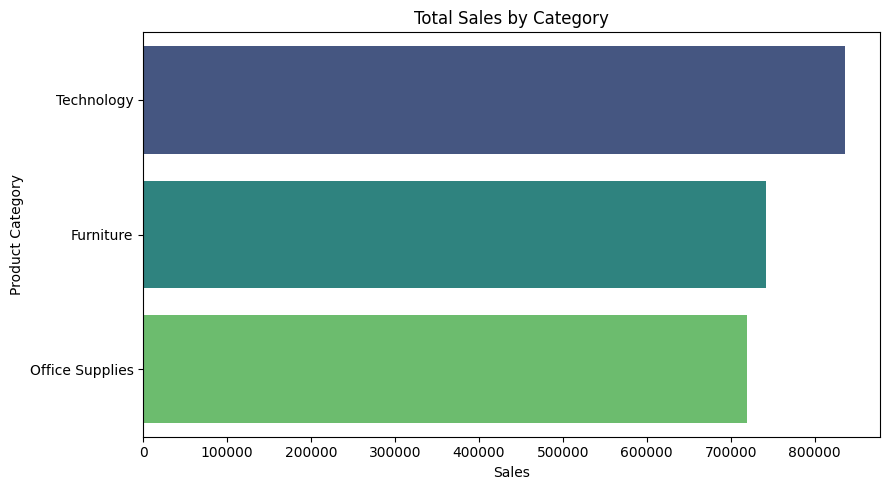

In [8]:
top_categories = df.groupby('Category')['Sales'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(9,5))
sns.barplot(data=top_categories, x='Sales', y='Category', hue='Category', palette='viridis', legend=False)
plt.title('Total Sales by Category')
plt.xlabel('Sales')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


## 🌍 Sales by Region

This visualization compares total sales across different regions.

**Key Insight:**  
The *West* and *East* regions outperform the *Central* and *South* regions in overall sales.

**Business Implication:**  
Regions with lower sales could be further analyzed to uncover potential for market expansion or improved outreach.


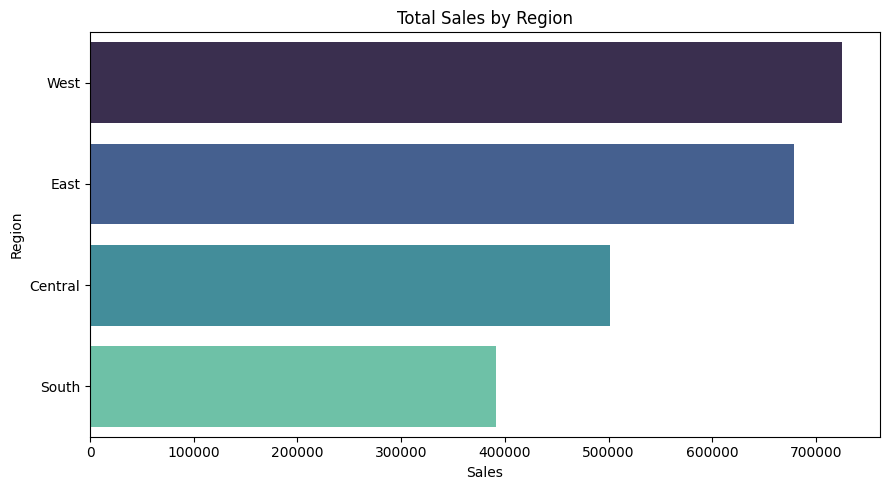

In [9]:
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(9,5))
sns.barplot(data=region_sales, x='Sales', y='Region', hue='Region', palette='mako', legend=False)
plt.title('Total Sales by Region')
plt.tight_layout()
plt.show()


## 💸 Sales vs. Discount

This scatter plot explores the relationship between discounts and sales.

**Key Insight:**  
While small discounts often correlate with higher sales, very high discounts (>30%) do not necessarily lead to higher revenue.  
There is significant variation, and in some cases, deep discounts may reduce profitability without boosting sales volume.

**Business Implication:**  
Optimize discount strategies to balance sales growth and profit margins. Avoid over-discounting unless it clearly drives demand.


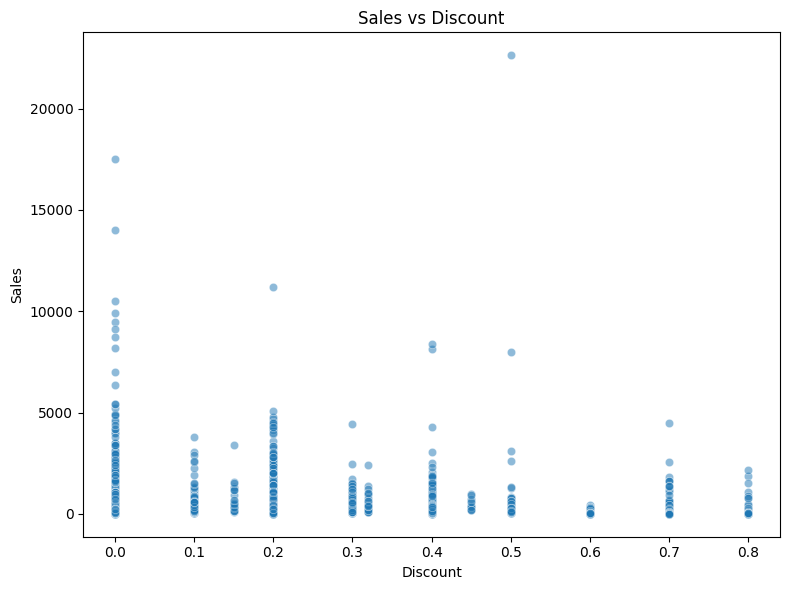

In [10]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Discount', y='Sales', alpha=0.5)
plt.title('Sales vs Discount')
plt.xlabel('Discount')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


### 📊 Insights from Radial Chart: Sales by Region and Ship Mode

- The **East** and **West** regions are the **major contributors** to overall sales.
- **Standard Class** is the **most preferred and widely used** shipping method across all four regions.
- It is also the **most profitable** shipping method, indicating strong customer adoption and operational efficiency.
- **Same Day Delivery** is the **least popular** shipping method in every region, suggesting limited demand or higher cost sensitivity.
- Across all regions, there's a clear **dominance of Standard shipping**, making it a key area for operational focus and potential optimization.


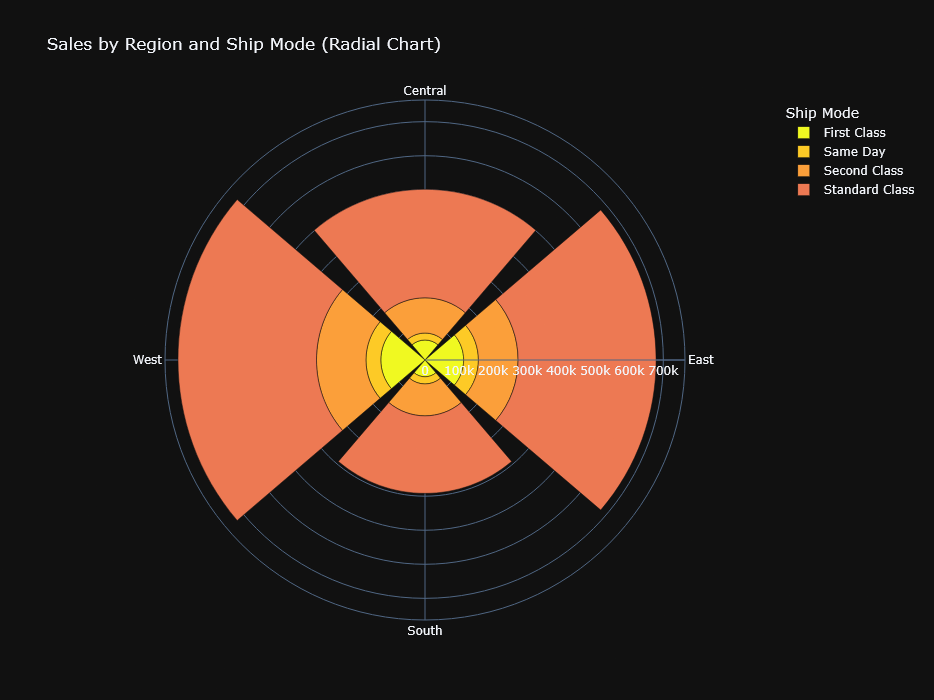

In [20]:
# Group by Region and Ship Mode to get total sales
agg = df.groupby(['Region', 'Ship_Mode'])['Sales'].sum().reset_index()

# Create a polar bar chart
fig = px.bar_polar(
    agg,
    r='Sales',
    theta='Region',
    color='Ship_Mode',
    template='plotly_dark',
    title='Sales by Region and Ship Mode (Radial Chart)',
    color_discrete_sequence=px.colors.sequential.Plasma_r
)

fig.update_layout(
    polar=dict(
        radialaxis=dict(showticklabels=True, ticks=''),
        angularaxis=dict(direction='clockwise')
    ),
    legend_title_text='Ship Mode',
    height=700
)

fig.show()


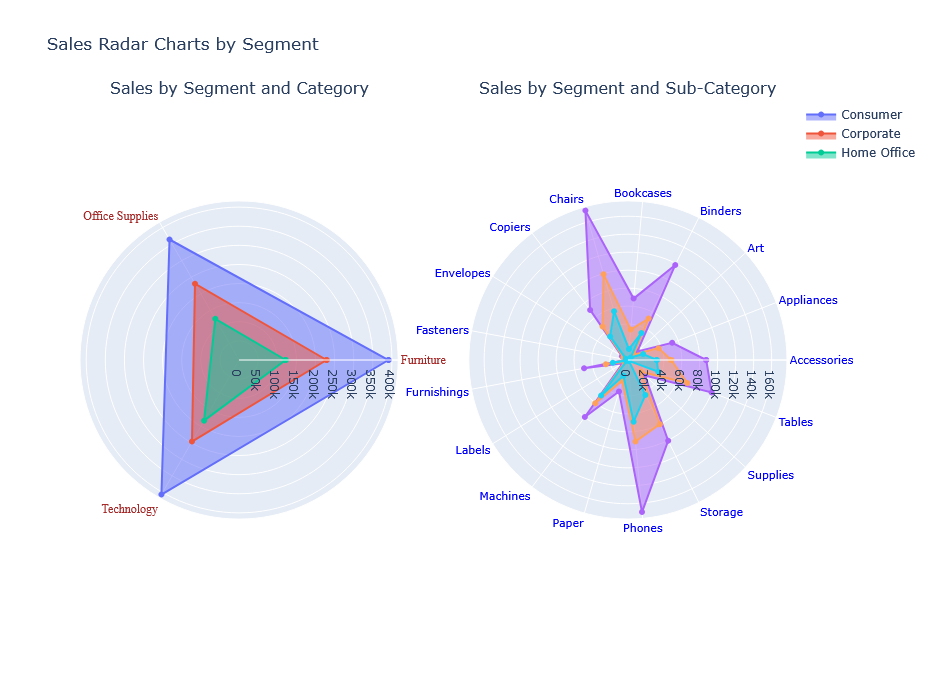

In [59]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Prepare subplot layout with two polar charts side by side
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'polar'}, {'type': 'polar'}]],
                    subplot_titles=[
                        "Sales by Segment and Category",
                        "Sales by Segment and Sub-Category"
                    ])

# ---------- First chart: Segment vs Category ----------
agg1 = df.groupby(['Segment', 'Category'])['Sales'].sum().reset_index()
segments1 = agg1['Segment'].unique()
categories1 = agg1['Category'].unique()

for seg in segments1:
    r_values = []
    for cat in categories1:
        val = agg1[(agg1['Segment'] == seg) & (agg1['Category'] == cat)]['Sales']
        r_values.append(val.values[0] if not val.empty else 0)

    fig.add_trace(go.Scatterpolar(
        r=r_values + [r_values[0]],
        theta=list(categories1) + [categories1[0]],
        fill='toself',
        name=seg,
        subplot='polar'
    ), row=1, col=1)

# ---------- Second chart: Segment vs Sub-Category ----------
agg2 = df.groupby(['Segment', 'Sub-Category'])['Sales'].sum().reset_index()
segments2 = agg2['Segment'].unique()
categories2 = agg2['Sub-Category'].unique()

for seg in segments2:
    r_values = []
    for cat in categories2:
        val = agg2[(agg2['Segment'] == seg) & (agg2['Sub-Category'] == cat)]['Sales']
        r_values.append(val.values[0] if not val.empty else 0)
    fig.add_trace(go.Scatterpolar(
        r=r_values + [r_values[0]],
        theta=list(categories2) + [categories2[0]],
        fill='toself',
        name=seg,
        showlegend=False,  # Legend already shown in first plot
        subplot='polar2'
    ), row=1, col=2)

# Update layout
fig.update_layout(
    height=700,
    title_text="Sales Radar Charts by Segment",
    showlegend=True,
    polar=dict(
        radialaxis=dict(visible=True),
        angularaxis=dict(tickfont=dict(size=12,color='brown', family='Comic')) 
    ),
    polar2=dict(
        radialaxis=dict(visible=True),
        angularaxis=dict(tickfont=dict(size=11,color='blue', family='Verdana'))  
    )
)

fig.show()


the plot on the left tells us: 
consumer segment in technology category has the highest sale drivers. next is corporate segment and last is home offoice segment. in all of the segment, technology has the highest sales, corporate and home office people for them furniture is the lowest sales and for consumers office supplies is the lowest sales category.

the plot on the right hand side with the subcategories tells us: 




In [11]:
df.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State',
       'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub-Category',
       'Product_Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Month'],
      dtype='object')

In [26]:
df['Sub-Category'].value_counts()

Sub-Category
Binders        1523
Paper          1370
Furnishings     957
Phones          889
Storage         846
Art             796
Accessories     775
Chairs          617
Appliances      466
Labels          364
Tables          319
Envelopes       254
Bookcases       228
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: count, dtype: int64

In [16]:
df['Region'].value_counts()

Region
West       3203
East       2848
Central    2323
South      1620
Name: count, dtype: int64

In [18]:
df['Sales'].value_counts()

Sales
12.960     56
19.440     39
15.552     39
25.920     36
10.368     36
           ..
4.240       1
319.960     1
646.740     1
81.940      1
243.160     1
Name: count, Length: 5825, dtype: int64